In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [16, 8]

# Trouvons tous les contours principaux

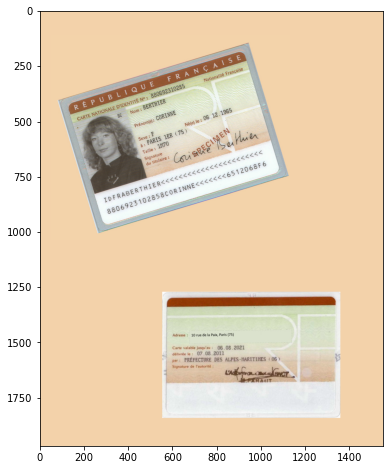

In [3]:
im = cv.imread('CI RetV.png')
plt.imshow(im)

## On passe en niveau de gris

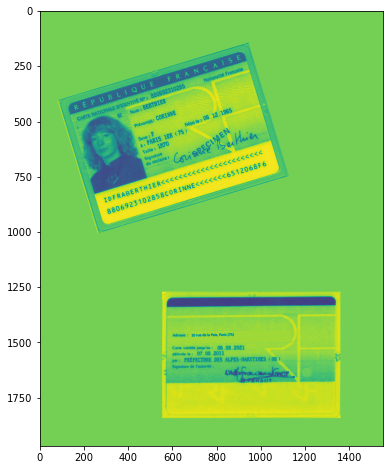

In [4]:
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(imgray)

## On utilise l'agorithme de détection de bords "Canny" (via OpenCV)

Au préalable on applique un flou gaussien (également connu sous le nom de lissage gaussien) qui donne le flou d'une image par une fonction gaussienne.

On applique ensuite un détecteur de bord Canny qui est un algorithme à plusieurs étages qui permet de détecter une large gamme de bords dans les images. Il a été développé par John F. Canny en 1986.

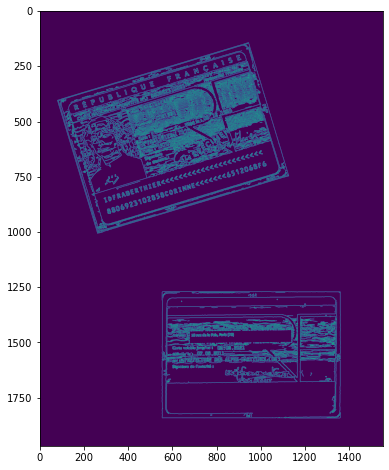

In [5]:
grayf = cv.GaussianBlur(imgray, (5, 5), 1)
edged = cv.Canny(grayf, 0, 50)
plt.imshow(edged)

## Détection de contours

Un seuillage avant :

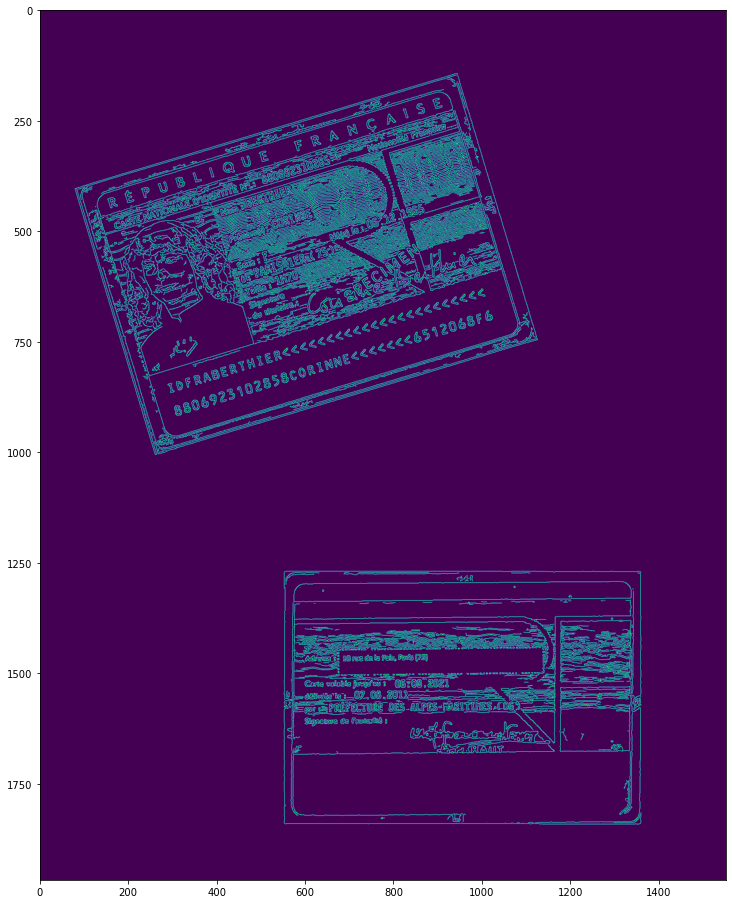

In [6]:
plt.rcParams['figure.figsize'] = [32, 16]
ret, thresh = cv.threshold(edged, 127, 255, 0)
plt.imshow(thresh)

In [7]:
#contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

In [8]:
contours = sorted(contours, key=cv.contourArea, reverse=True)

La détection de contours renvoit 2 objets:
* une liste (python) des points formant chaque contours
* un tableau des hiararchies de contours

Nombre de contours, nous en avons ici 1214 au total (cf. ci-dessous). Chaque élément de la liste contours contient un ensemble de points qui forme le polygone du contour :

In [9]:
len(contours)

1906

Le tableau hiérarchie est un tableau de 3 dimensions et a la forme suivante :  
`hierarchy[index][{0,1,2,3}] = { next contour (same level), 
                                previous contour (same level), 
                                child contour, 
                                parent contour}`  
-1 signifie pas de contour

In [10]:
hierarchy.shape

(1, 1906, 4)

On restreint les contours aux parents seulement

In [11]:
onlyParents = []
for i in range(hierarchy.shape[1]):
    if (hierarchy[0][i][3] < 0):
        onlyParents.append(contours[i])
len(onlyParents)

1906

In [12]:
im_target = im.copy()
x = cv.drawContours(im_target, onlyParents, -1, (0,255,0), 3)

Voici sur l'image les contours conservés.

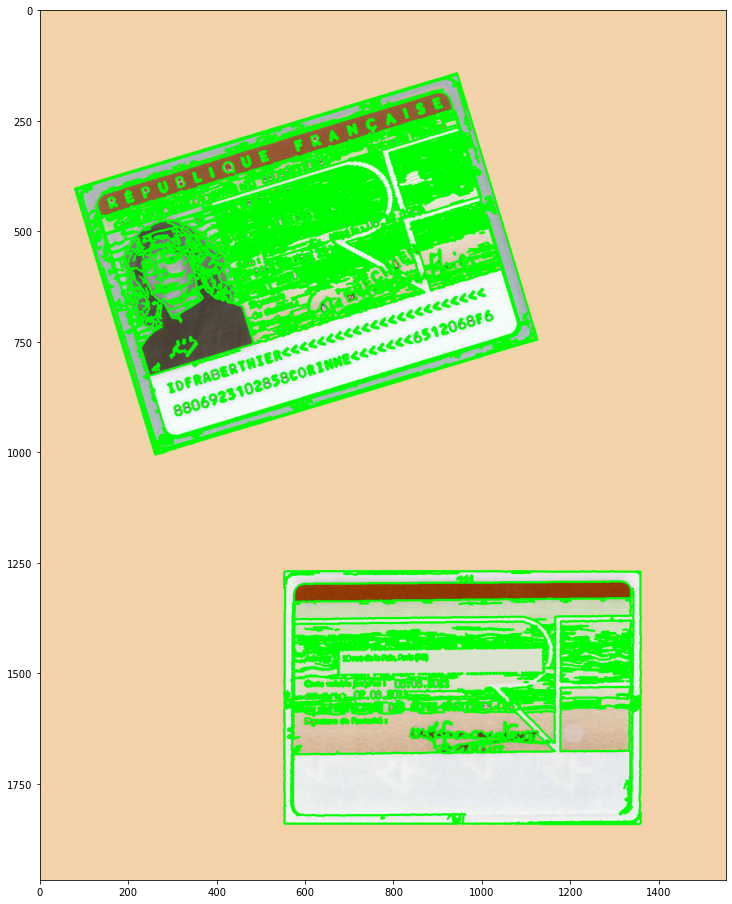

In [13]:
plt.imshow(im_target)

# On va découper la page (2 docs) via l'utilisation d'un algorithme de clustering (k-means)

In [14]:
import pandas as pd
from sklearn.cluster import KMeans

In [15]:
len(onlyParents)

1906

On met à plat les points

In [16]:
flatlist = []
for i in range(len(onlyParents)):
    j=0
    #for j in range(len(onlyParents[i])):
    flatlist.append(onlyParents[i][j]) # on ne prend qu'un point par contour

In [17]:
len(flatlist)

1906

In [18]:
X = pd.DataFrame(columns=['X', 'Y'])
s = 0
for i in range(len(flatlist)):
        X.loc[s, 'X'] = flatlist[i][0][0]
        X.loc[s, 'Y'] = flatlist[i][0][1]
        s = s + 1

In [19]:
X.head()

,X,Y
0,1276,1292
1,1328,1530
2,848,354
3,1162,1455
4,618,640


In [20]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [21]:
y = pd.DataFrame(kmeans.labels_)
y.head()

,0
0,0
1,0
2,1
3,0
4,1


## Nous avons séparé en deux cluster, maintenant nous allons prendre les coordonnées extremes de ces deux clusters

Par cluster on cherche 2 points (bord haut/gauche et bas/droite), ca revient a chercher
* La coordonnée la plus a gauche ainsi que la plus à droite (plus grand et plus petit x)
* La coordonnée la plus en haut ainsi que la plus basse (plus grand et plus petit y)

In [22]:
y.loc[0, 0]

0

In [23]:
def getRectFromCluster(cluster):
    X0hg = 500000
    Y0hg = 500000
    X0bd = 0
    Y0bd = 0
    for index, point in X.iterrows():
        if (y.loc[index, 0]==cluster):
            # cluster 0
            if (X.loc[index, 'X'] < X0hg):
                X0hg = X.loc[index, 'X']
            elif (X.loc[index, 'X'] > X0bd):
                X0bd = X.loc[index, 'X']
            if (X.loc[index, 'Y'] < Y0hg):
                Y0hg = X.loc[index, 'Y']
            elif (X.loc[index, 'Y'] > Y0bd):
                Y0bd = X.loc[index, 'Y']
    print("Haut/Gauche -->", X0hg, Y0hg)
    print("Bas droite -->", X0bd, Y0bd)
    return (int(X0hg), int(Y0hg)), (int(X0bd), int(Y0bd))
p01, p02 = getRectFromCluster(0)
p11, p12 = getRectFromCluster(1)

Haut/Gauche --> 552 1269
Bas droite --> 1358 1838
Haut/Gauche --> 101 143
Bas droite --> 1121 998


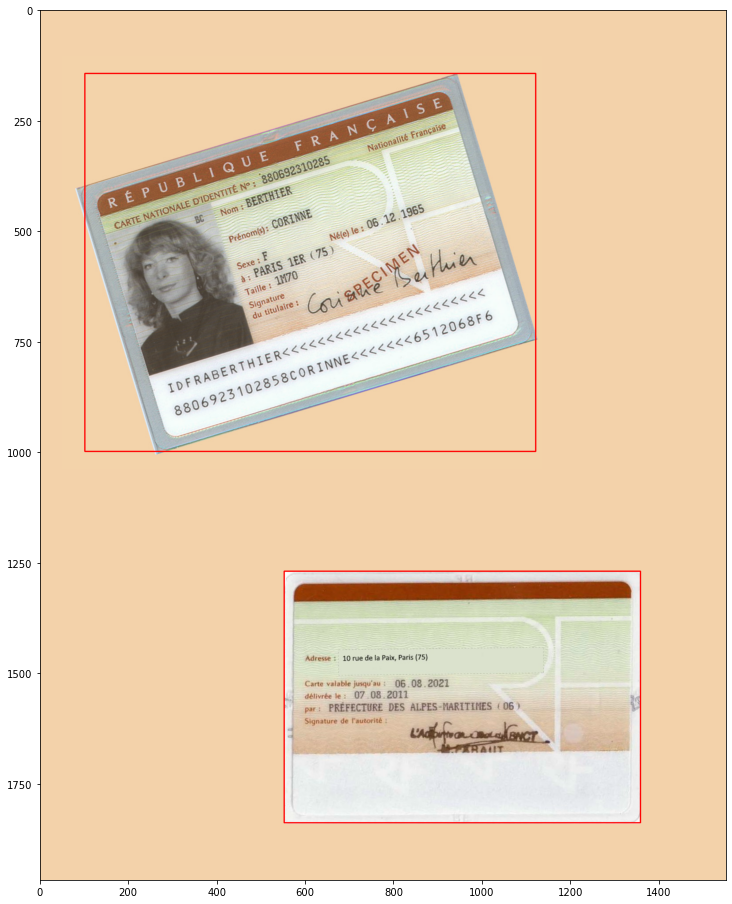

In [25]:
color = (255, 0, 0) 
thickness = 2
imgfinal = cv.rectangle(im, p01 , p02, color, thickness)
imgfinal = cv.rectangle(imgfinal, p11 , p12, color, thickness)
plt.imshow(imgfinal)